<a href="https://colab.research.google.com/github/beanie00/2022-EE538-HW/blob/main/EE538_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1

Bayes classifier로 decision boundary를 구할 때, 두 class의 posterior probability가 같은 지점이 decision boundary가 된다. 오차를 고려해 +- 0.01만큼 차이 내로 posterior가 같은 지점을 찾아 plot 하였다. Single layer perceptron으로 구한 decision boundary는 선형이었음에 반해 Bayes classifier로 구한 decision boundary는 non-linear하고 따라서 더 정확함을 볼 수 있다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import pandas as pd
import math

def makeSample(S, T, N1, N2, c1, c2):
  X_1, X_2, Y_1, Y_2 = [[], [], [], []]
  label = ['exp(-1((x-1)^2+y^2)/2*{})'.format(c1),'exp(-1((x+1)^2+y^2)/2*{})'.format(c2)]
  fig, ax = plt.subplots()

  while (len(X_1) < N1 or len(X_2) < N2):
    if (len(X_1) < N1):
      x1 = np.random.uniform(-20, 20)
      y1 = np.random.uniform(-20, 20)
      p1 = np.exp(-1*((x1-1)**2+y1**2)/(2*c1)) / (2*c1*np.pi)
      isPlot = np.random.binomial(n=1, p=p1, size=1)
      if (isPlot):
        X_1.append(x1)
        Y_1.append(y1)
        S.append([x1, y1])
        T.append(-1)
    if (len(X_2) < N2):
      x2 = np.random.uniform(-20, 20)
      y2 = np.random.uniform(-20, 20)
      p2 = np.exp(-1*((x2+1)**2+y2**2)/(2*c2)) / (2*c2*np.pi)
      isPlot = np.random.binomial(n=1, p=p2, size=1)
      if (isPlot):
        X_2.append(x2)
        Y_2.append(y2)
        S.append([x2, y2])
        T.append(1)

  ax.scatter(X_1,Y_1, color='red', label=label[0], alpha=0.1)
  ax.scatter(X_2,Y_2, color='blue', label=label[1], alpha=0.1)
  ax.legend()
  ax.grid(True)
  plt.title("Samples for N1={}, N2={}, c1={}, c2={}".format(N1, N2, c1, c2))
  plt.show()
  return [X_1, X_2, Y_1, Y_2]

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
class SingleLayerPerceptron(object):

  def __init__(self, eta=0.01, epochs=50):
      self.eta = eta
      self.epochs = epochs

  def train(self, X, y):
      self.w_ = np.zeros(X.shape[1])
      self.b_ = 0.5
      self.errors_ = []

      for _ in range(self.epochs):
          errors = 0
          for xi, target in zip(X, y):
              update = self.eta * (target - self.predict(xi))
              self.w_ +=  update * xi
              self.b_ +=  update
              errors += int(update != 0.0)
          self.errors_.append(errors)
      return self

  def net_input(self, X):
      return np.dot(X, self.w_) + self.b_

  def predict(self, X):
      return np.tanh(self.net_input(X))

In [ ]:
class NaiveBayesDecisionBoundary():
  '''
  Bayes Theorem form
  P(y|X) = P(X|y) * P(y) / P(X)
  '''
  def calc_prior(self, samples, target):
    self.prior = (samples.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

    return self.prior
  
  def calc_statistics(self, samples, target):
    self.mean = samples.groupby(target).apply(np.mean).to_numpy()
    self.var = samples.groupby(target).apply(np.var).to_numpy()
          
    return self.mean, self.var
  
  def gaussian_density(self, class_idx, x):     
    mean = self.mean[class_idx]
    var = self.var[class_idx]
    numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var))
    denominator = np.sqrt(2 * np.pi * var)
    prob = numerator / denominator
    return prob
  
  def calc_posterior(self, x):
    posteriors = []
    # calculate posterior probability for each class
    for i in range(self.count):
        prior = np.log(self.prior[i])
        conditional = np.sum(np.log(self.gaussian_density(i, x))) # use the log to make it more numerically stable
        posterior = prior + conditional
        posteriors.append(posterior)
    '''
    두 class의 posterior probability가 같은 지점이 decision boundary이다. 오차를 고려해 +- 0.005만큼 차이 내로 posterior가 같은 지점을 찾아 선형 근사를 해주었다.
    '''
    if (1-0.01 < posteriors[0]/posteriors[1] < 1+0.01):
      self.decision_boundary_x.append(x[0])
      self.decision_boundary_y.append(x[1])
    return self.classes[np.argmax(posteriors)]
    

  def fit(self, samples, target):
    self.classes = np.unique(target)
    self.count = len(self.classes)
    self.sample_nums = samples.shape[1]
    self.rows = samples.shape[0]
    self.decision_boundary_x = []
    self.decision_boundary_y = []
    
    self.calc_statistics(samples, target)
    self.calc_prior(samples, target)
      
  def predict(self, samples):
    preds = [self.calc_posterior(s) for s in samples.to_numpy()]

  def get_decision_boundary(self):
    return [self.decision_boundary_x, self.decision_boundary_y]

In [ ]:
from scipy import interpolate

def plot_result(S, T, XY):
  label = ['(x-2)2+y2<2', 'x2+(y-2)2<3']
  X_1, X_2, Y_1, Y_2 = XY
  # run Naive Bayes
  decision_boundary = run_naive_bayes(S, T)
  decision_boundary_x = decision_boundary[0]
  decision_boundary_y = decision_boundary[1]

  # run Single layer perceptron
  ppn = SingleLayerPerceptron(epochs=500, eta=0.05)
  ppn.train(np.array(S), np.array(T))
  x = np.arange(-5,5)

  # plot Naive Bayes
  plt.plot(decision_boundary_x, decision_boundary_y,'o', label='Bayes Decision Boundary', color='indigo')

  # plt.plot(decision_boundary_x, decision_boundary_y)
  # plot Single layer perceptron
  plt.plot(x, -1*(ppn.w_[0]/ppn.w_[1])*x - ppn.b_/ppn.w_[1], label='Single-layer Perceptron Decision Boundary', color='black', linestyle='--')
  plt.scatter(X_1,Y_1, color='red', alpha=0.1)
  plt.scatter(X_2,Y_2, color='blue', alpha=0.1)
  plt.legend()
  plt.xlim(-4,4) 
  plt.ylim(-4,4)
  plt.show()

def run_naive_bayes(S, T):
  df = pd.DataFrame((zip(list(zip(*S))[0], list(zip(*S))[1], T)), columns = ['x', 'y', 'target'])
  X, y = df.iloc[:, :-1], df.iloc[:, -1]
  x = NaiveBayesDecisionBoundary()
  x.fit(X, y)
  x.classes, x.sample_nums, x.rows, x.count
  x.calc_prior(X, y)
  x.calc_statistics(X, y)
  x.predict(X)
  decision_boundary = x.get_decision_boundary()
  return decision_boundary

### (1.a)

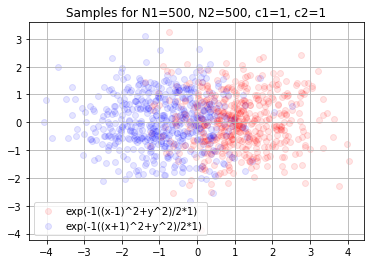

In [ ]:
S1 = []
Target1 = []
XY1 = makeSample(S1, Target1, 500, 500, 1, 1)

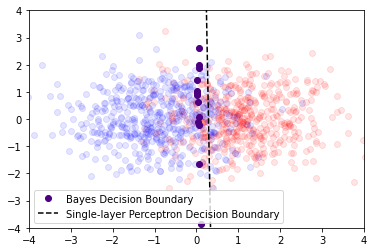

In [ ]:
plot_result(S1, Target1, XY1)

### (1.b)

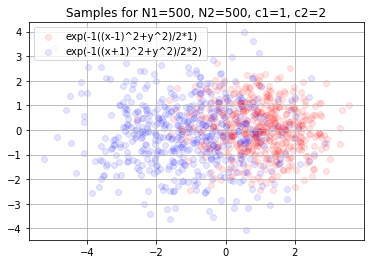

In [ ]:
S2 = []
Target2 = []
XY2 = makeSample(S2, Target2, 500, 500, 1, 2)

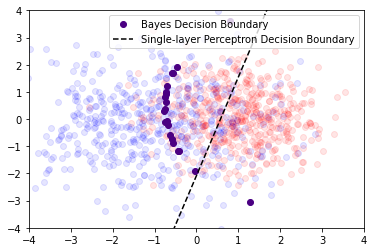

In [ ]:
plot_result(S2, Target2, XY2)

### (1.c)

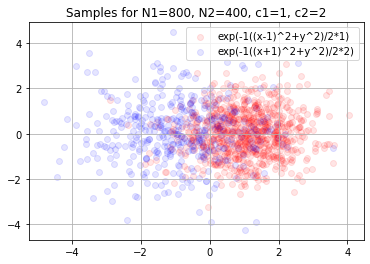

In [ ]:
S3 = []
Target3 = []
XY3 = makeSample(S3, Target3, 800, 400, 1, 2)

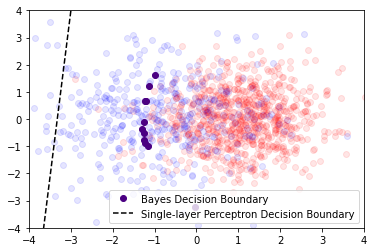

In [ ]:
plot_result(S3, Target3, XY3)

# Problem 3

In [ ]:
def makeSample_prob3(S):
  N1 = 500
  N2 = 500
  X_1, X_2, Y_1, Y_2 = [[], [], [], []]
  fig, ax = plt.subplots()

  while (len(X_1) < N1 or len(X_2) < N2):
    if (len(X_1) < N1):
      x1 = np.random.uniform(-20, 20)
      y1 = np.random.uniform(-20, 20)
      if (y1 > 0 and (x1+4)**2+y1**2 > 36 and (x1+4)**2+y1**2 < 100):
        X_1.append(x1)
        Y_1.append(y1)
        S.append([x1, y1])
    if (len(X_2) < N2):
      x2 = np.random.uniform(-20, 20)
      y2 = np.random.uniform(-20, 20)
      if (y2 < 3 and (x2-4)**2+(y2-3)**2 > 36 and (x2-4)**2+(y2-3)**2 < 100):
        X_2.append(x2)
        Y_2.append(y2)
        S.append([x2, y2])

  ax.scatter(X_1,Y_1, color='red', alpha=0.1)
  ax.scatter(X_2,Y_2, color='blue', alpha=0.1)
  ax.grid(True)
  plt.title("Samples for prob 3")
  plt.show()
  return [X_1, X_2, Y_1, Y_2]

In [ ]:
def competitive_learning(S, dimension) :
  n_iterations = 300
  learning_rate = 0.6

  # initialize w
  w = np.random.rand(dimension, 2)

  error_list = []
  for n in range(n_iterations):
    e = 0
    if (n > 0): 
      learning_rate = 0.4 * learning_rate
    for s in S:
      # get current cluster
      distance = []
      for i in range(dimension) : 
        distance.append(np.linalg.norm(s-w[i]))
      cur_cluster_index = np.argmin(distance, axis=0)
      # update w
      e += (s[0] - w[cur_cluster_index][0])**2 + (s[1] - w[cur_cluster_index][1])**2
      w[cur_cluster_index] = w[cur_cluster_index] + learning_rate * (s - w[cur_cluster_index])
    error_list.append(e / len(S1))

  plt.plot(range(len(error_list)), error_list)
  plt.title("Learning curve; "+str(dimension)+ ' cluster')
  plt.xlabel('$epoch$')
  plt.ylabel('$error$')
  plt.show()
  return w

In [ ]:
def plot_cluster_result(w, dimension) :
  w_x, w_y = [[], []]
  for i in range(dimension) : 
    w_x.append(w[i][0])
    w_y.append(w[i][1])
  plt.scatter(w_x,w_y, color='black', label='cluster mean', alpha=1)

  for s in S:
      # get current cluster
      distance = []
      for i in range(dimension) : 
        distance.append(np.linalg.norm(s-w[i]))
      cur_cluster_index = np.argmin(distance, axis=0)
      if (cur_cluster_index == 0):
        plt.scatter(s[0],s[1], color='red', alpha=0.1)
      elif (cur_cluster_index == 1):
        plt.scatter(s[0],s[1], color='green', alpha=0.1)
      elif (cur_cluster_index == 2):
        plt.scatter(s[0],s[1], color='blue', alpha=0.1)
      elif (cur_cluster_index == 3):
        plt.scatter(s[0],s[1], color='yellow', alpha=0.1)
      elif (cur_cluster_index == 4):
        plt.scatter(s[0],s[1], color='violet', alpha=0.1)
      elif (cur_cluster_index == 5):
        plt.scatter(s[0],s[1], color='lime', alpha=0.1)
      elif (cur_cluster_index == 6):
        plt.scatter(s[0],s[1], color='darkorange', alpha=0.1)
      elif (cur_cluster_index == 7):
        plt.scatter(s[0],s[1], color='darkcyan', alpha=0.1)

  plt.xlim(-15,15) 
  plt.ylim(-15,15)
  plt.title("Clustered results; "+str(dimension)+ ' cluster')
  plt.legend()
  plt.grid(True)

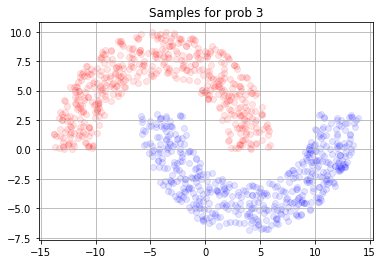

In [ ]:
S = []
XY = makeSample_prob3(S)

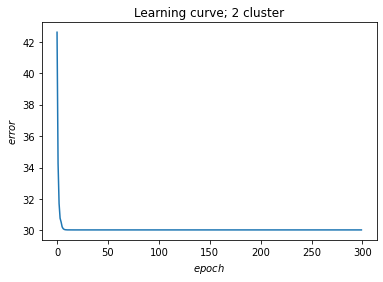

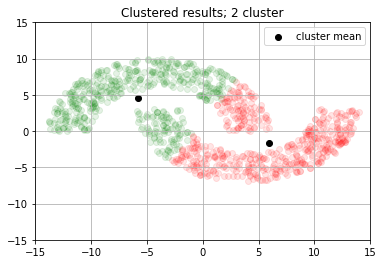

In [ ]:
w = competitive_learning(S, 2)
plot_cluster_result(w, 2)

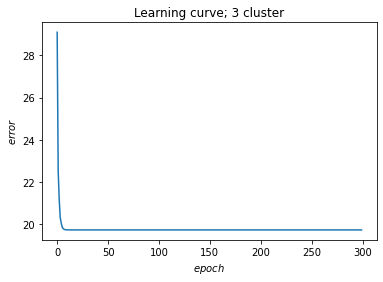

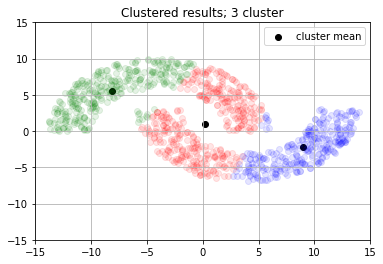

In [ ]:
w = competitive_learning(S, 3)
plot_cluster_result(w, 3)

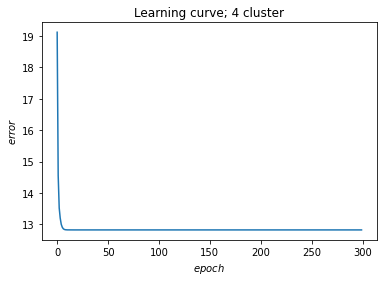

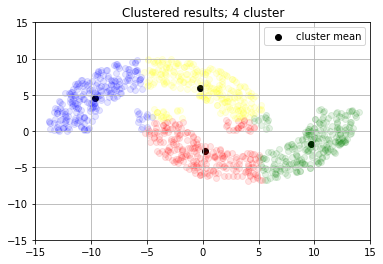

In [ ]:
w = competitive_learning(S, 4)
plot_cluster_result(w, 4)

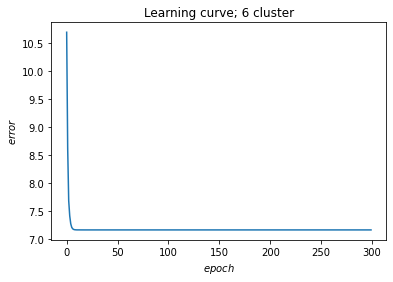

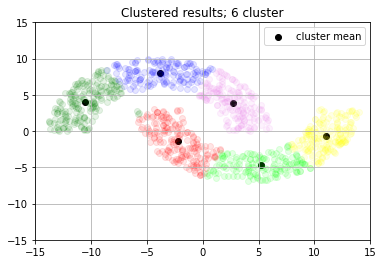

In [ ]:
w = competitive_learning(S, 6)
plot_cluster_result(w, 6)

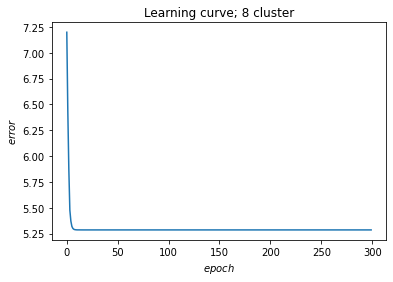

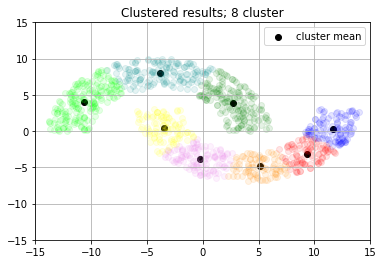

In [ ]:
w = competitive_learning(S, 8)
plot_cluster_result(w, 8)